# Food Vision Big

In this workbook we will use all of the data from the Food101 DataSet to train our model.

Out goal is to beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) with 10% of the training (leveraging the power of deep learning). Their accuracy was 50.76%.

More details [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).


# Setup Notebook Imports and Ensure Correct Versions of Software

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import sys
import os
import pathlib
import random
import urllib.request
import datetime


In [2]:
import helpers.tf_classification_helper_functions as helpers
import imp
imp.reload(helpers)
helpers.show_environment()
helpers.show_gpu_info()

Setting Up Libraries

Python Version: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]


Tensorflow Version: 2.4.1


SciKit Learn Versions:

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True
C:\Users\timar\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


GPU Device Name: /devic

In [3]:
# See what GPUs we have
!nvidia-smi -L
!nvidia-smi

GPU 0: GeForce RTX 2080 Ti (UUID: GPU-30bd7d38-6b4b-ccf0-e238-1cb4edd477dd)
Sun Apr 18 22:27:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:2C:00.0  On |                  N/A |
|  0%   36C    P2    61W / 300W |    969MiB / 11264MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
            

# Setup Notebook Variables

In [4]:
#
# #Setup variables for our data
#
if os.name == "nt":
    base_data_dir = "C:/Users/timar/tensorflow_datasets/food101"
else:
    base_data_dir = "/home/pi/tensorflow_datasets/food101"

#zip_download_file = f"{base_data_dir}/101_food_classes_10_percent.zip"
#zip_extract_location = base_data_dir
#data_dir = f"{base_data_dir}/101_food_classes_10_percent"

#train_data_dir = data_dir + "/train"
#test_data_dir = data_dir + "/test"

#data_source_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"

#
# Setup variables for our model training
#
# Create a tensorboard callback
if os.name == "nt":
    base_model_dir = "c:/temp/data/06_models"
else:
    base_model_dir = "/home/pi/Dev/data/06_models"

tensorboard_dir = base_model_dir + "/tensorboard"
model_checkpoint_dir = base_model_dir + "/checkpoints"
saved_model_dir = base_model_dir + "/saved"

# Download the Data

We will use TensorFlow DataSets to load our data.


In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?


True


In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load (
        name="food101", # target dataset to get from TFDS
        split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
        shuffle_files=True, # shuffle files on download?
        as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
        with_info=True # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)
    ) 

erating validation examples...: 22821 examples [00:23, 224.79 examples/s]

Generating validation examples...: 22844 examples [00:23, 220.48 examples/s]

Generating validation examples...: 22867 examples [00:23, 220.36 examples/s]

Generating validation examples...: 22891 examples [00:23, 224.77 examples/s]

Generating validation examples...: 22915 examples [00:23, 228.22 examples/s]

Generating validation examples...: 22939 examples [00:23, 229.32 examples/s]

Generating validation examples...: 22962 examples [00:23, 228.85 examples/s]

Generating validation examples...: 22985 examples [00:23, 222.95 examples/s]

Generating validation examples...: 23009 examples [00:24, 226.26 examples/s]

Generating validation examples...: 23032 examples [00:24, 227.02 examples/s]

Generating validation examples...: 23055 examples [00:24, 226.23 examples/s]

Generating validation examples...: 23078 examples [00:24, 224.37 examples/s]

Generating validation examples...: 23101 examples [00:24, 225.36 ex

## Exploring the Food 101 data from TensorFlow DataSets

To become one with our data, we want to find:
* Class Names
* The shape of our input data (image tensors)
* The data type of our input data
* What the labels look like (eg are they one hot encoded or are they label encoded)
* Do the labels match with the class names?


In [10]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [20]:
# Take on sample from our training data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [21]:
# What does one sample of our training data look like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [22]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape}
    Image Datatype: {image.dtype}
    Target Class from Food101 (tensor form): {label}
    Class Name (str form): {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3)
    Image Datatype: <dtype: 'uint8'>
    Target Class from Food101 (tensor form): 93
    Class Name (str form): steak
    


In [23]:
# What does our image tensor look like from TFDS's Food 101 Dataset?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[113,  50,  41],
        [111,  48,  39],
        [109,  46,  37],
        ...,
        [243, 226, 219],
        [242, 223, 217],
        [241, 222, 216]],

       [[117,  54,  45],
        [114,  51,  42],
        [111,  48,  39],
        ...,
        [230, 210, 201],
        [226, 203, 197],
        [221, 198, 190]],

       [[118,  58,  50],
        [116,  56,  48],
        [113,  53,  45],
        ...,
        [179, 149, 138],
        [169, 136, 127],
        [159, 127, 116]],

       ...,

       [[232, 241, 248],
        [232, 241, 248],
        [232, 241, 248],
        ...,
        [194, 183, 179],
        [194, 183, 179],
        [194, 183, 179]],

       [[231, 240, 247],
        [231, 240, 247],
        [232, 241, 248],
        ...,
        [194, 183, 179],
        [194, 183, 179],
        [194, 183, 179]],

       [[231, 240, 247],
        [231, 240, 247],
        [231, 240, 247],
        ...,
        [194, 183, 17

In [24]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

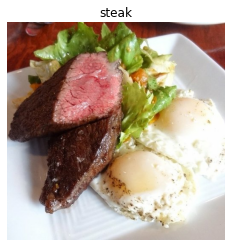

In [25]:
# Plot an image from tensorflow datasets
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# Create Preprocesing Functions for our Data

Neural networks perform best when data is in a certain way (eg batched, normalized, etc)

However, not all data (including data from TensorFlow datasets) come like this.

So in order to get it ready for a neural network, you'lloften have to write preprocessing functions and map it to your data.

What we know about our data:
* Its in unit8 datatype
* Comprised of all different sized tensors (images)
* Not scaled (so the pixel values are between 0 and 255)

What we know models like:
* Data in float32 dtype (or for mixed precision float16 and float32)
* For batches, tensorflow likes all of the tensors witrhin a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientBx pretrained model from tf.keras.applications we dont need to rescale our data (these architectures have rescaling built in).

This means our function needs to:
* 1. Reshape our images to all the same size
* 2. Convert the dtype of our images from uint8 to float32



In [27]:
# Make a function for preprocessing images
def preprocess_img(image,  label, img_shape=224):
    """
    Converts image datatype from uint8 to float32 and reshapes image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape,img_shape])
    #image = image/255. # Scale image values. Not required with EfficientNetBx models
    return tf.cast(image, tf.float32), label # return a tuple of (float32_image, label)

In [28]:
# Preprocess a single sampleimage and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n{image[:2]}..., \nShape:{image.shape}) \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}..., \nShape:{preprocessed_img.shape}) \nDatatype: {preprocessed_img.dtype}")
preprocessed_img

Image before preprocessing:
[[[113  50  41]
  [111  48  39]
  [109  46  37]
  ...
  [243 226 219]
  [242 223 217]
  [241 222 216]]

 [[117  54  45]
  [114  51  42]
  [111  48  39]
  ...
  [230 210 201]
  [226 203 197]
  [221 198 190]]]..., 
Shape:(512, 512, 3)) 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
[[[113.87245   50.87245   41.87245 ]
  [109.091835  46.091835  37.091835]
  [112.06633   49.06633   40.06633 ]
  ...
  [243.97449  228.12238  224.41829 ]
  [238.95403  219.69382  213.59685 ]
  [230.43864  208.86722  202.40799 ]]

 [[117.31122   57.908165  49.908165]
  [112.93368   52.933674  44.933674]
  [108.37245   48.37245   40.37245 ]
  ...
  [155.57123  118.78546  107.759964]
  [141.12746  102.70395   88.056   ]
  [121.188446  79.85681   66.16293 ]]]..., 
Shape:(224, 224, 3)) 
Datatype: <dtype: 'float32'>


<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[113.87245 ,  50.87245 ,  41.87245 ],
        [109.091835,  46.091835,  37.091835],
        [112.06633 ,  49.06633 ,  40.06633 ],
        ...,
        [243.97449 , 228.12238 , 224.41829 ],
        [238.95403 , 219.69382 , 213.59685 ],
        [230.43864 , 208.86722 , 202.40799 ]],

       [[117.31122 ,  57.908165,  49.908165],
        [112.93368 ,  52.933674,  44.933674],
        [108.37245 ,  48.37245 ,  40.37245 ],
        ...,
        [155.57123 , 118.78546 , 107.759964],
        [141.12746 , 102.70395 ,  88.056   ],
        [121.188446,  79.85681 ,  66.16293 ]],

       [[110.86224 ,  54.290817,  47.719387],
        [112.71429 ,  56.142857,  49.571426],
        [111.35714 ,  52.571426,  47.      ],
        ...,
        [131.995   ,  69.831696,  50.6633  ],
        [136.64285 ,  70.09693 ,  49.683666],
        [138.49492 ,  71.352066,  51.13778 ]],

       ...,

       [[231.      , 240.      , 247.      ],
        [231.

# OLD STUFF

In [ ]:
# Make the base data directory if it doesnt exist
if not os.path.exists(base_data_dir):
    os.makedirs(base_data_dir)

In [ ]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
if not os.path.isfile(zip_download_file):
    !wget $data_source_url -O $zip_download_file

In [ ]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile(zip_download_file)
    zip_ref.extractall(path=zip_extract_location)
    zip_ref.close()

In [ ]:
# Walk through the data directory and list number of files
helpers.walk_directory(data_dir)

# 1. Visualize our Images

In [ ]:
# Show the class names we have
class_names = helpers.get_class_names_from_directory(data_dir+"/train/")
print(class_names), len(class_names)

In [ ]:
# View a random image from the training data set
helpers.view_random_images_from_directory (
    directory = train_data_dir, 
    class_names = class_names,
    #Optionally pass in a specific class to show only images from that class
    #class_to_show = random.choice(class_names),
    num_images=4,
    figsize=(20,20)
)

# 2. Preprocess our Images

Our next step is to turn our data into batches and load our training and test sets.

A batch is a small subset of data. Rather than look at all ~10k images, a model might only look at 32 at a time. 

It does this for a couple of reasons:
* 10k images might not fit into the memory of the procesor
* Trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well.

Why 32?

Because 32 is good for your health per Yann Lecun. (google yann lecun batchsize, see his twitter post). Yann Lecun is a professor at NYU

In [ ]:
#Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set the seed for reproducibility
tf.random.set_seed(RANDOM_SEED)

# image_dataset_from_directory creates a tf.data.DataSet return type and is faster
# than using ImageDataGenerator.flow_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory (
    directory=train_data_dir,
    # Reshape all the images to be the same size. 
    image_size=IMAGE_SIZE,
    label_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    batch_size = BATCH_SIZE,
    seed = RANDOM_SEED
)

test_data = tf.keras.preprocessing.image_dataset_from_directory (
    directory=test_data_dir,
    # Reshape all the images to be the same size. 
    image_size=IMAGE_SIZE,
    label_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    batch_size = BATCH_SIZE,
    seed = RANDOM_SEED,
    shuffle=False # Dont shuffle the test data, we want it to stay in the same order so we can better evaluate it later
)


In [ ]:
#Shape is 224x224 image with 3 color channels, and then a 1 hot encoded label
train_data

In [ ]:
# How many batches are there. 
# Multiply this by BATCH_SIZE should get you a number equal to about the number of images in the dataset
len(train_data)

In [ ]:
# Load the specified number of batches from our image dataset, and show random images
helpers.view_random_images_from_tf_dataset(dataset=train_data, class_names=class_names, batches=2, num_images=8, figsize=(20,15))

# Model_0 - the base Feature Extraction Model

## Create Model 0: Building a transfer learning feature extraction model using the Keras Functional API

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the Model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs) on the train dataset and validate on 15% of the test data to save epoch time.



In [ ]:
#
# Setup callbacks
#
# TensorBoard callback
tensorboard_callback = helpers.create_tensorboard_callback(tensorboard_dir, "model_0")
# Model Checkpoint callback
checkpoint_callback = helpers.create_model_checkpoint_callback(model_checkpoint_dir, "model_0")

#
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
# 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
    #tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Keep for models like Resnet50V2, but EfficientNets have rescaling built in
], name="data_augmentation")


#
# Create a base model with tf.keras.applications
# The top layer has 1000 output neurons for the model trained on ImageNet. We want to
# be able to specify that our model has a different number of outputs
#
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# Create inputs into our model. Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3),  name="input_layer")

# Augment Images (only happens during training phase)
x = data_augmentation(inputs)

# Pass the inputs to the base model
# Training = false puts the base model in inference mode so weights which need to stay frozen, stay frozen
x = base_model(x, training=False)

print(f"Shape after passing inputs through base model: {x.shape}")

# Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the Model
model_0.compile (
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model and save its history
history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    # We can tweak the number of validation steps if we want to try to speed it up by 
    # not validating on everything in the folder.
    #validation_steps=len(test_data),
    # Only validate on 15% of the test data
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[tensorboard_callback, checkpoint_callback]
)


In [ ]:
# Get a summary of the model we created
model_0.summary()

In [ ]:
# Layers in loaded model
model_0.layers

In [ ]:
# What layers in the model are trainable
for i, layer in enumerate(model_0.layers):
    print(i, layer.name, layer, layer.trainable)

In [ ]:
# Look at the layers within the efficient net v0 model and see if they are trainable
for i, layer in enumerate(model_0.layers[2].layers):
    print(i, layer.name, layer, layer.trainable)

In [ ]:
#How many variables in the efficent net layer are trainable?
print(len(model_0.layers[2].trainable_variables))

## Evaluate Model 0: Building a transfer learning feature extraction model using the Keras Functional API

In [ ]:
# Lets evaluate model_0 now
model_0.evaluate(test_data)

In [ ]:
# Checkout the loss and accuracy of the model
# Ideally the two curves should be very close to each other.
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
# If the model is overfitting (learning the training data too well) it will get great results on the 
# training data, but it is failing to generalize well to unseen data and it performs poorly on the test data.
helpers.plot_loss_curves(history_0)

# Model_1 - fine tune Model_0 (the base Feature Extraction Model)

In [ ]:
# Make a clone of the model_0 that we can fine tune model_1

# We have 3 ways we can clone the model to allow us to fine tune a new one:
# 1. Clone the model and copy the weights (cloning does not copy weights)
model_1 = tf.keras.models.clone_model(model_0)
model_1.set_weights(model_0.get_weights()) 

# 2. Clone the model and load the weights from the checkpoint
#model_1 = tf.keras.models.clone_model(model_0)
#model_1.load_weights(f"{model_checkpoint_dir}/model_0/model_0")

# 3. Save the model and reload it
#model_0.save(f"{saved_model_dir}/model_0")
#model_1 = tf.keras.models.load_model(f"{saved_model_dir}/model_0")


# Unfreeze all of the layers in the base model (efficientnetb0 layer)
model_1.layers[2].trainable = True

# Refreeze every layer except the last 5
# Layers[2] is the the efficientnetb0 layer. Find its index by looking at model_1.layers
for layer in model_1.layers[2].layers[:-5]:
    layer.trainable = False

# Its typically best practice to lower the learning rate by 10x when fine tuning
# Compile the Model
model_1.compile (
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
    metrics=["accuracy"]
)

In [ ]:
# What layers in the model are trainable
for i, layer in enumerate(model_1.layers):
    print(i, layer.name, layer, layer.trainable)

In [ ]:
# What layers from the base model are now trainable
for i, layer in enumerate(model_1.layers[2].layers):
    print(i, layer.name, layer, layer.trainable)

In [ ]:
# Fit the model and save its history

# Setup callbacks
# TensorBoard callback
tensorboard_callback = helpers.create_tensorboard_callback(tensorboard_dir, "model_1")
# Model Checkpoint callback
checkpoint_callback = helpers.create_model_checkpoint_callback(model_checkpoint_dir, "model_1")

# We want to fine tune for 5 more epochs from our base feature extraction model
num_fine_tune_epochs = len(history_0.epoch) + 5

history_1 = model_1.fit(
    train_data,
    epochs=num_fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    # We can tweak the number of validation steps if we want to try to speed it up by 
    # not validating on everything in the folder.
    #validation_steps=len(test_data),
    # Only validate on 15% of the test data
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[tensorboard_callback, checkpoint_callback],
    initial_epoch=history_0.epoch[-1]
)

In [ ]:
# Lets evaluate model_1 now
model_1_results = model_1.evaluate(test_data)
model_1_results

In [ ]:
# The training loss continues to decline, but the validation loss has plateaued. 
# The model is still overfitting
helpers.compare_loss_curves(history_0, history_1)

# Saving and loading our model

To use our model in an external application we'll need to save it and export it somewhere.

In [ ]:
# Save our fine tuned model model_1
model_1.save(f"{saved_model_dir}/model_1")


In [ ]:
# Load and evaluate the saved model
model_1_loaded = tf.keras.models.load_model(f"{saved_model_dir}/model_1")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
model_1_loaded_results = model_1_loaded.evaluate(test_data)
model_1_loaded_results

In [ ]:
# The results from our initial model_1 and the model_1_loaded should be very similar
model_1_results, model_1_loaded_results


In [ ]:
np.isclose(model_1_results, model_1_loaded_results)

# Evaluating the performance of model_1 across all different classes

Let's make some predictions, visualize them, and then later find out which predictions were the "most" wrong.

In [ ]:
# Make predictions with model
preds_probs = model_1.predict(test_data, verbose=1) # Set verbosity to see how long it is

In [ ]:
# this is the number of batches (each with 32 images) in the test dataset
len(test_data)

In [ ]:
# Whatrs the shape of our predictions
# 25,250 images, 101 classes
preds_probs.shape

In [ ]:
# Lets see what 10 predictions look like
preds_probs[:10]

In [ ]:
# What does the first prediction probability look like
# Out model outputs a prediction probability array (with N number of variables, where 
# N is the number of classes) for each sample passed to the predict method.
preds_probs[0], len(preds_probs[0])

In [ ]:
# We get one prediction probability per class (in our case there are 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")
# Just show the class name tied to the probability
class_names[np.argmax(preds_probs[0])]

In [ ]:

# Get the predicted classes across all ~25k test data samples
pred_classes = preds_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

In [ ]:
# How many pred classes do we have?
len(pred_classes)

Now we've got a predictions array of all of our models predictions. To evaluate them, we need to compare them to the ground truth labels.

In [ ]:
# To get our test labels, we need to unravel our test_data BatchDataset
y_labels = []

#unbatch will unbatch the whole data set, and create an aray of the ground truth label for every image
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

# look at the first 10 labels
y_labels[:10] 

In [ ]:
# How many y_labels are there
len(y_labels)

## Evaluating our models predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.


In [ ]:
# Accuracy score is in model_1_loaded_results[1]
model_1_loaded_results

In [ ]:
# Lets try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(
    y_true = y_labels,
    y_pred = pred_classes
)
sklearn_accuracy

In [ ]:
#Does this metric come close to our models evaluate results?
np.isclose(model_1_loaded_results[1], sklearn_accuracy)

## Lets get visual: making a Confusion Matrix

In [ ]:
imp.reload(helpers)
helpers.make_confusion_matrix(
    y_true = y_labels,
    y_pred = pred_classes,
    class_names = class_names.tolist(), #or we could use test_data.class_names and then not have to cast to a list
    figsize=(100,100),
    text_size=20
)

# Lets keep the evaluation train going. Time for a Classification Report

Scikit learn has a helpful function for acquiring many different classification metrics per class (eg precision, recall, and F1) called classification report.

Here are various classifcation model evaluation methods:
* Accuracy - default metric for classification. Not the best for imbalanced classes.
* Precision - higher precision leads to less false positives
* Recall - higher recall leads to less false negatives
* F1-Score - combination of precision and recall, usually a good overall metric for a classification model
* Confusion matrix - When comparing predictions to truth labels to see where model gets confused. Can be hard to use with large numbers of classes.

In [ ]:
# This shows the results class by class (for al 101 classes)
from sklearn.metrics import classification_report
class_report = classification_report(y_true=y_labels, y_pred=pred_classes)
print(class_report)


In [ ]:
pred_classes

In [ ]:
imp.reload(helpers)
helpers.plot_classification_report(y_true=y_labels, y_pred=pred_classes, class_names=class_names, figsize=(30,30), text_size=15, metric="f1-score")

# Finding the most wrong predictions

To find out where out model is most wrong, let's write some code to find out the following:
* 1. Get all of the image file paths in the test dataset using the list_files() method
* 2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class names.
* 3. Use our dataframe to find all the wrong predictions (where the ground truth label doesnt match the prediction).
* 4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top)
* 5. Visualize the images with the highest prediction probabilitys but have the wrong prediction.

In [ ]:
#TODO Make me a function. Name it plot_most_wrong_predictions
#Params should be figsize,image_file_path, y_true, y_pred, prediction_probabilities,class_names,num_images_to_view,

# 1. Get all of the image file paths in the test dataset
filepaths = []
#TODO is there a better way to do this then having to re-read in the file names?
for filepath in tf.data.Dataset.list_files(f"{test_data_dir}/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
#filepaths[:10]

# 2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class names.
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": preds_probs.max(axis=1), #Get the maximum predicted probability value
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})
#pred_df

# 3. Use our dataframe to find all the wrong predictions (where the ground truth label doesnt match the prediction).
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
#pred_df

# 4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top)
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
#top_100_wrong

# 5. Visualize the images with the highest prediction probabilitys but have the wrong prediction.
num_images_to_view = 9
start_index = 0
plt.figure(figsize=(15,15))
#Get the first N rows as defined in num_images_to_view
for i, row in enumerate(top_100_wrong[start_index : start_index + num_images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    #print(row.img_path)
    # The image path comes in as a bytes object, needs to be converted to a string, and then we replace
    # backslashes with slashes so we can make a url
    img_path = row.img_path.decode("utf-8") .replace('\\', '/')
    url = f"file:///{img_path}"
    #print(url)
    raw_img, prepped_img = helpers.load_and_prep_image(url, normalize_image=True)
    #print(img)
    plt.imshow(prepped_img)
    plt.title(f"Actual: {row.y_true_classname}\nPredicted: {row.y_pred_classname}\nProbability: {row.pred_conf}")
    plt.axis(False)
    #print(row)


# Test Predictions on our Best Model using images from the Web

In [ ]:
imp.reload(helpers)
#
# Make some test predictions on images from the web
#
def show_test_prediction (url):
    helpers.predict_and_plot_image(
        model_1, 
        class_names = class_names,
        url = url,
        normalize_image=False)

#Steak
show_test_prediction("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg")
show_test_prediction("https://hips.hearstapps.com/del.h-cdn.co/assets/18/08/1519155106-flank-steak-horizontal.jpg")
show_test_prediction("file:///c:/temp/data/10_food_classes_10_percent/10_food_classes_10_percent/test/chicken_curry/838.jpg")

#Pizza
show_test_prediction("https://slice.seriouseats.com/images/2012/08/animatedpizzagifs-deal-with-it.gif")
show_test_prediction("https://upload.wikimedia.org/wikipedia/commons/1/10/Pepperoni_pizza.jpeg")
show_test_prediction("https://www.kindpng.com/picc/m/3-33626_download-pizza-png-picture-pizza-png-transparent-png.png")

#Curry
show_test_prediction("https://images.squarespace-cdn.com/content/v1/57bb2e8cb3db2b9076db6369/1529609506001-AI7Y83VYPGIFN3SVU7AB/ke17ZwdGBToddI8pDm48kLkXF2pIyv_F2eUT9F60jBl7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iyqMbMesKd95J-X4EagrgU9L3Sa3U8cogeb0tjXbfawd0urKshkc5MgdBeJmALQKw/AdobeStock_142271660.jpeg")



# Comparing our Models Results Using Tensorboard

Tensorboard.dev lets you easily host, track and view our results.
Note that when you upload things to tensorboard.dev, your experiments are public. If you are running private experiments, do not upload to TensorBoard.dev

To setup tensorboard locally do this :
* pip3 install -U tensorboard
* specify the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY` environment variable.
> set TENSORBOARD_BINARY=C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\tensorboard.exe
* Also put that folder in the PATH
> set PATH=%PATH%;C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\
* Example to launch from command line:
> C:\Users\timar\AppData\Roaming\Python\Python38\Scripts\tensorboard.exe --logdir=C:/Temp/data/tensorboard/

In [ ]:
%load_ext tensorboard
#%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=$tensorboard_dir --name "Transfer Learning Experiments with 101 Food101 Classes"
#%tensorboard --logdir=C:/Temp/data/tensorboard/efficientnet_1

In [ ]:
from IPython.display import IFrame
IFrame('http://localhost:6006', width=700, height=350)